# Setup

In [46]:
%matplotlib inline

In [47]:
# Library imports
from fastai.vision.all import *
from nbdev.showdoc import *

set_seed(42) # for reproducible random numbers

In [48]:
# Change this to another device (0-7) if you run out of memory
# Goto Kernel->Restart&Clear Output after changing the device
torch.cuda.set_device(6)

In [49]:
# Batch size: https://docs.paperspace.com/machine-learning/wiki/epoch
# Typically 32 works fine, feel free to experiment with it
# If you run out of memory, try to lower the number
bs = 32

# Get Data

We'll use the MNIST Dataset (http://yann.lecun.com/exdb/mnist/) and try to predict handwritten digits.

Here's a list of available datasets: https://docs.fast.ai/data.external.html

In [50]:
path = 'plant_seedlings_v2'


In [51]:
fns=get_image_files(path)
fns

(#5539) [Path('plant_seedlings_v2/black_grass/1.png'),Path('plant_seedlings_v2/black_grass/10.png'),Path('plant_seedlings_v2/black_grass/100.png'),Path('plant_seedlings_v2/black_grass/101.png'),Path('plant_seedlings_v2/black_grass/102.png'),Path('plant_seedlings_v2/black_grass/103.png'),Path('plant_seedlings_v2/black_grass/104.png'),Path('plant_seedlings_v2/black_grass/105.png'),Path('plant_seedlings_v2/black_grass/106.png'),Path('plant_seedlings_v2/black_grass/107.png')...]

# Step 1 - Data Loader

In [52]:
weeds=DataBlock(blocks=(ImageBlock,CategoryBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=(0.2),seed=42),
               get_y=parent_label,item_tfms=Resize(224))

Note: Use the Datablocks API and answer the following quetions:
* A) What are the types of our inputs and targets?
* B) Where is the data?
* C) How do we know if a sample is in the training or the validation set?
* D) How do we know the label of an image?
* E) Which item transforms do we want to perform?
* F) Which batch transforms do we want to perform?

In [53]:
dls=weeds.dataloaders(path,num_workers = 0,bs=64)

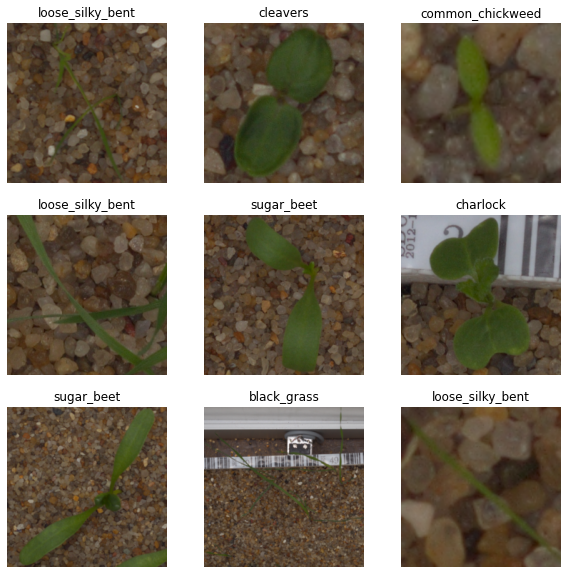

In [22]:
dls.show_batch(max_n=9, figsize=(10,10))

# Step 2 - Building a Model

In [23]:
learner=cnn_learner(dls,resnet18,metrics=[accuracy, error_rate])

# Step 3 - Learning

In [24]:
learner.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.205868,0.746435,0.758808,0.241192,00:50
1,1.013303,0.443668,0.840108,0.159892,00:50
2,0.601839,0.414686,0.852755,0.147245,00:49


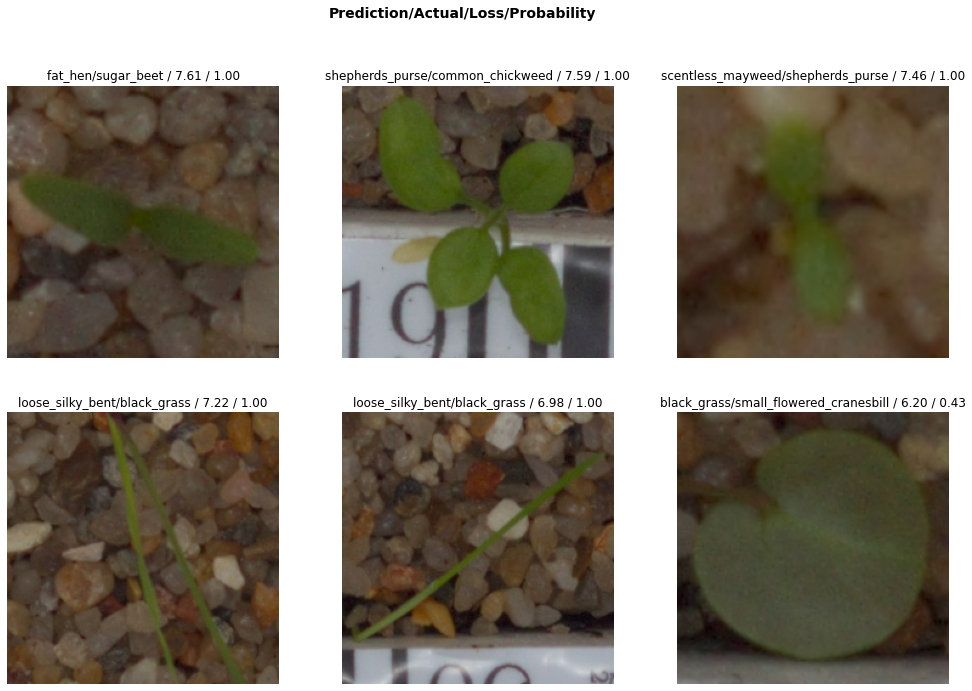

In [30]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(6, figsize=(17,11))

In [31]:
learner.fine_tune(2, 3e-2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.312402,0.573491,0.892502,0.107498,00:52


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.832926,1.248467,0.755194,0.244806,00:51
1,0.377025,0.231520,0.921409,0.078591,00:50


In [33]:
learner.save('stage-1_0.08')

Path('models/stage-1_0.08.pth')

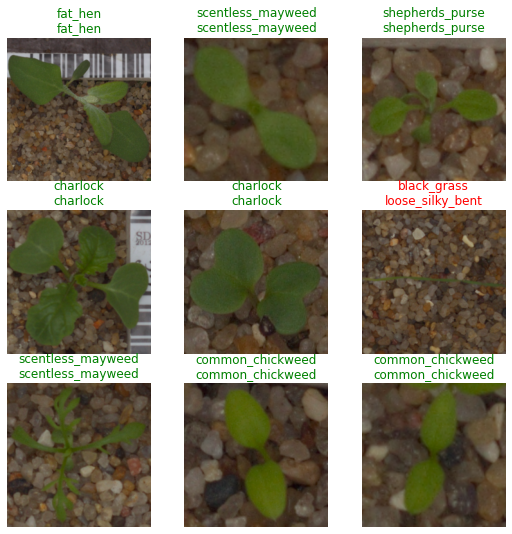

In [34]:
learner.show_results()

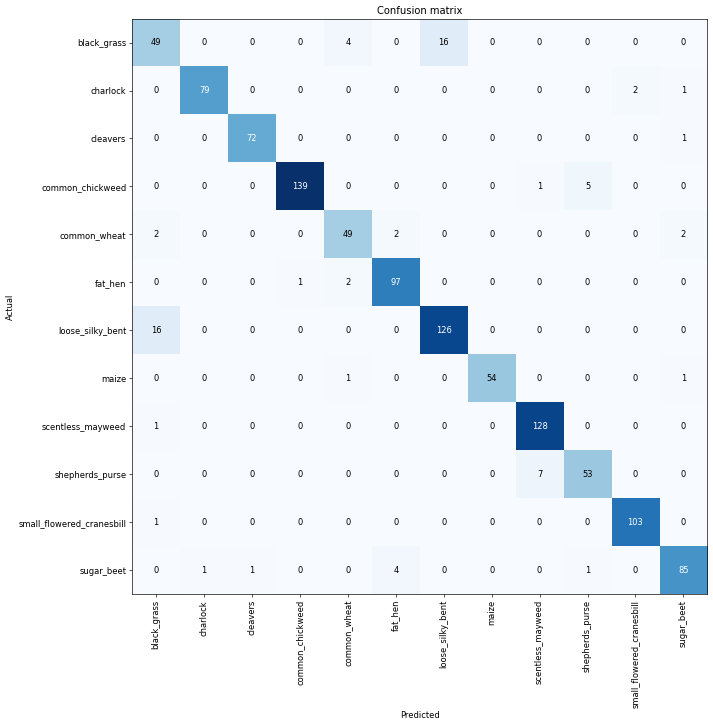

In [35]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Optimization

/home/ele_group_2/miniconda3/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


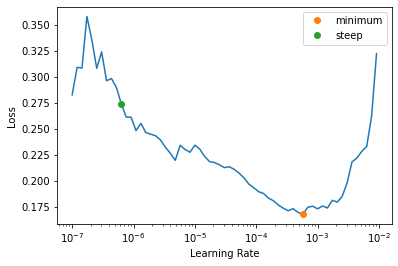

In [36]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

In [37]:
interpretation.most_confused(min_val=2)

[('black_grass', 'loose_silky_bent', 16),
 ('loose_silky_bent', 'black_grass', 16),
 ('shepherds_purse', 'scentless_mayweed', 7),
 ('common_chickweed', 'shepherds_purse', 5),
 ('black_grass', 'common_wheat', 4),
 ('sugar_beet', 'fat_hen', 4),
 ('charlock', 'small_flowered_cranesbill', 2),
 ('common_wheat', 'black_grass', 2),
 ('common_wheat', 'fat_hen', 2),
 ('common_wheat', 'sugar_beet', 2),
 ('fat_hen', 'common_wheat', 2)]

In [94]:
learner = cnn_learner(dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0012022644514217973)

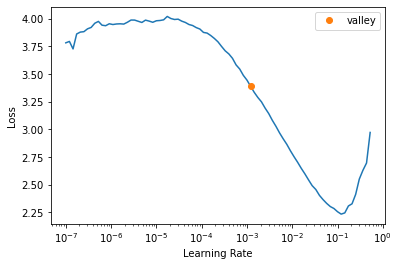

In [95]:
learner.lr_find()

In [96]:
learner.fit_one_cycle(3, lr_max=0.0014)

epoch,train_loss,valid_loss,error_rate,time
0,1.295171,0.411546,0.132791,00:58
1,0.501121,0.270565,0.096658,00:57
2,0.246092,0.236491,0.083108,01:00


In [98]:
learner.fine_tune(3, 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.324150,0.661771,0.128275,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.676969,283.951111,0.777778,01:09
1,0.420908,0.299154,0.100271,01:00
2,0.199332,0.146438,0.052394,00:59


In [41]:
learner.save('stage-2_0.06')

Path('models/stage-2_0.06.pth')

In [100]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.9476061426103115


# Resnet 152

In [54]:
learner = cnn_learner(dls, resnet152, metrics=error_rate)

In [55]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.066085,0.621615,0.200542,01:14
1,0.825486,0.266234,0.096658,01:10
2,0.367232,0.224900,0.079494,01:09
3,0.209569,0.186989,0.060524,01:07
4,0.120315,0.181661,0.063234,01:07
5,0.069730,0.184328,0.056007,01:10
6,0.039487,0.186588,0.059621,01:06
7,0.022846,0.173519,0.048780,01:06
8,0.014314,0.174492,0.046974,01:05
9,0.011147,0.172164,0.046974,01:05


In [79]:
learner.fine_tune(10, 3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.247272,2.100367,0.309846,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.219649,0.874111,0.058717,01:12
1,0.253895,51.958172,0.456188,01:12
2,0.329774,0.369508,0.109304,01:10
3,0.225615,0.280074,0.080397,01:13
4,0.142232,0.460112,0.099368,01:13
5,0.097799,0.230827,0.057814,01:13
6,0.061379,0.190637,0.046974,01:12
7,0.040461,0.197076,0.049684,01:12
8,0.031592,0.171475,0.039747,01:16
9,0.015929,0.157645,0.039747,01:13


In [80]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.9602529369294643


In [81]:
learner.save('stage-3_0.04')

Path('models/stage-3_0.04.pth')

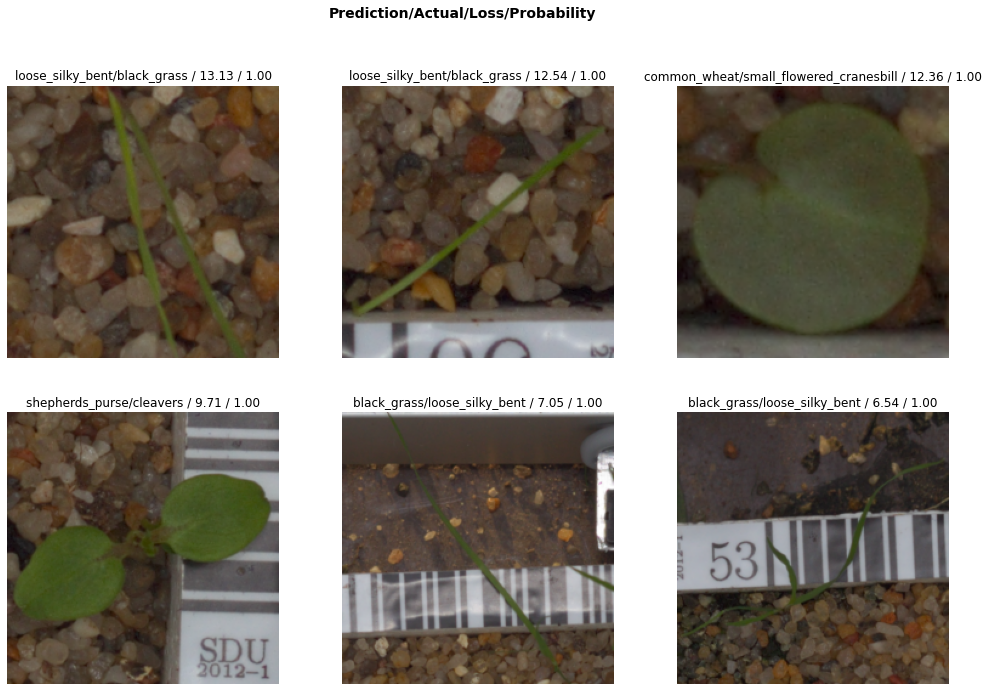

In [82]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(6, figsize=(17,11))

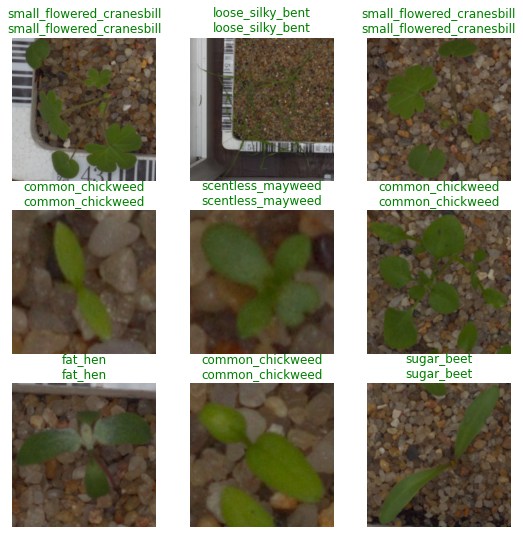

In [83]:
learner.show_results()

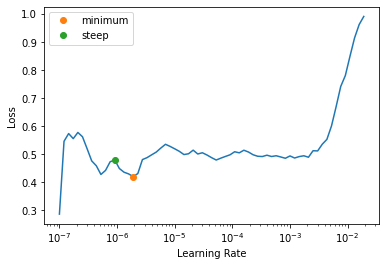

In [60]:
lr_min,lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

In [70]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.91e-07, steepest point: 9.12e-07


In [75]:
learner.unfreeze()
learner.fit_one_cycle(3, lr_max=slice(9.12e-8,9.12e-7))

epoch,train_loss,valid_loss,error_rate,time
0,0.171554,0.215335,0.063234,01:11
1,0.177874,0.262635,0.059621,01:14
2,0.186896,0.388631,0.064137,01:22


In [73]:
lr_steep

9.12010818865383e-07

In [85]:
interpretation.most_confused(min_val=2)

[('loose_silky_bent', 'black_grass', 11),
 ('black_grass', 'loose_silky_bent', 10),
 ('shepherds_purse', 'scentless_mayweed', 3),
 ('common_chickweed', 'scentless_mayweed', 2),
 ('common_wheat', 'common_chickweed', 2),
 ('common_wheat', 'sugar_beet', 2),
 ('shepherds_purse', 'common_chickweed', 2)]

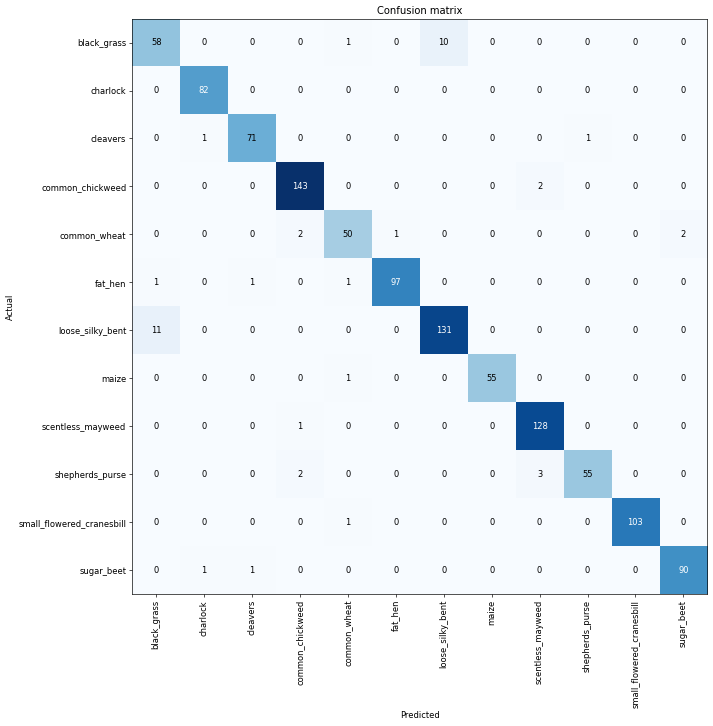

In [84]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)